# Machine Learning: Practice 4
Continuous data metrics and regression

By: Enrique Mena Camilo

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

sns.set_theme(style="darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

__author__ = "Enrique Mena Camilo"
__email__ = "enriquemece97@gmail.com"


## Utils

In [64]:
def currency_str_to_float(value: str) -> float:
    """_summary_

    :param str value: _description_
    :return float: _description_
    """
    return float(value.replace("$", "").replace(",", "") if isinstance(value, str) else value)


In [65]:
def get_histplot(data: pd.Series, title: str):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)
    sns.histplot(data, ax=ax, kde=True)
    ax.set_title(f"'{title}' distribution")
    plt.savefig(f"./figures/histplot_{title.lower()}.png", bbox_inches="tight")
    plt.show()


def get_boxplot(data: pd.Series, title: str):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)
    sns.boxplot(data, ax=ax)
    ax.set_title(f"'{title}' boxplot")
    plt.savefig(f"./figures/boxplot_{title.lower()}.png", bbox_inches="tight")
    plt.show()


def get_distribution_plots(data: pd.Series, title: str):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(18, 4)
    sns.histplot(data, ax=axes[0], kde=True)
    axes[0].set_title(f"'{title}' distribution")
    sns.boxplot(data, ax=axes[1])
    axes[1].set_title(f"'{title}' boxplot")
    axes[1].set_xlabel(data.name)
    plt.savefig(f"./figures/distribution_{title.lower()}.png", bbox_inches="tight")
    plt.show()


def plot_predictions(train_set: np.ndarray, test_set: np.ndarray, train_pred: np.ndarray, test_pred: np.ndarray, title: str):
    plt.figure(figsize=(8, 4))
    plt.scatter(train_set[0], train_set[1], s=10, label="Train data")
    plt.scatter(test_set[0], test_set[1], s=10, label="Test data")
    plt.plot(train_set[0], train_pred, linestyle="solid", label="Train predictions")
    plt.plot(test_set[0], test_pred, linestyle="solid", label="Test predictions")
    plt.title(f"{title} results")
    plt.xlabel("Date")
    plt.ylabel("Close/Last")
    plt.legend()
    plt.savefig(f"./figures/{'_'.join(title.lower().split())}_results", bbox_inches="tight")
    plt.show()


In [66]:
def get_heatmap(data: pd.DataFrame):
    """Build dataset correlation heatmap.
    """
    fig, ax = plt.subplots(1)
    fig.suptitle(f"Dataset's heatmap")
    fig.set_size_inches(8, 8)
    sns.heatmap(data=data.corr(), annot=True, cmap='BrBG', vmin=-1, vmax=1, ax=ax)
    plt.savefig(f"./figures/dataset_heatmap.png", bbox_inches='tight')
    plt.show()


In [67]:
# https://www.analyticsvidhya.com/blog/2021/10/evaluation-metric-for-regression-models/

def MSE(actual: np.ndarray, predicted: np.ndarray):
    return np.sum((actual - predicted)**2) / len(actual)


def RMSE(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(np.sum((actual - predicted)**2) / len(actual))


def MAE(actual: np.ndarray, predicted: np.ndarray):
    return np.sum(np.abs(actual - predicted)) / len(actual)


def RSE(actual: np.ndarray, predicted: np.ndarray):
    rse_n = np.sum((actual - predicted)**2)
    rse_d = np.sum((actual - actual.mean())**2)
    return rse_n / rse_d


def PCC(actual: np.ndarray, predicted: np.ndarray):
    pcc_n = len(actual)*np.sum(actual * predicted) - np.sum(actual)*np.sum(predicted)
    pcc_d1 = len(actual)*np.sum(actual**2) - np.sum(actual)**2
    pcc_d2 = len(actual)*np.sum(predicted**2) - np.sum(predicted)**2
    pcc_d = np.sqrt(pcc_d1 * pcc_d2)
    return pcc_n / pcc_d


def R2(actual: np.ndarray, predicted: np.ndarray):
    # Por qué algunos lo muestran como 1 - r2? https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/
    r2_n = np.sum((predicted - actual)**2)
    r2_d = np.sum((actual -  actual.mean())**2)
    return 1 - (r2_n / r2_d)


def evaluate_regression(actual: np.ndarray, predicted: np.ndarray):
    print(f"Mean Square Error: {round(MSE(actual, predicted), 2)}")
    print(f"Root Mean Square Error: {round(RMSE(actual, predicted), 2)}")
    print(f"Mean Absolute Error: {round(MAE(actual, predicted), 2)}")
    print(f"Relative Square Error: {round(RSE(actual, predicted), 2)}")
    print(f"Pearson Correlation Coeficient: {round(PCC(actual, predicted), 2)}")
    print(f"R-squared: {round(R2(actual, predicted), 2)}")


## Data pre-processing

### Data cleaning

Data loading

In [68]:
data = pd.read_csv("../data/Nasdaq.csv")
data.head()


,Date,Close/Last,Volume,Open,High,Low
0,12/02/2022,$105.05,7916878,$102.02,$105.54,$101.82
1,12/01/2022,$103.37,7452313,$102.33,$103.56,$101.95
2,11/30/2022,$102.2,15000770,$99.05,$102.56,$98.52
3,11/29/2022,$98.66,4423921,$98.96,$99.33,$98.2
4,11/28/2022,$98.66,5257862,$98.99,$100.16,$98.56


It is necessary to give the correct format to the columns

In [69]:
data["Date"] = pd.to_datetime(data["Date"])
data["Close/Last"] = data["Close/Last"].apply(currency_str_to_float)
data["Open"] = data["Open"].apply(currency_str_to_float)
data["High"] = data["High"].apply(currency_str_to_float)
data["Low"] = data["Low"].apply(currency_str_to_float)

data.head()


,Date,Close/Last,Volume,Open,High,Low
0,2022-12-02,105.05,7916878,102.02,105.54,101.82
1,2022-12-01,103.37,7452313,102.33,103.56,101.95
2,2022-11-30,102.20,15000770,99.05,102.56,98.52
3,2022-11-29,98.66,4423921,98.96,99.33,98.20
4,2022-11-28,98.66,5257862,98.99,100.16,98.56


The data is sorted descending, we need them sorted ascending

In [70]:
data = data.sort_values(by="Date", ascending=True, ignore_index=True)
data.head()


,Date,Close/Last,Volume,Open,High,Low
0,2022-06-06,78.98,7239429,79.70,81.2999,78.53
1,2022-06-07,79.47,5517101,78.57,79.7500,78.26
2,2022-06-08,78.47,5178253,78.90,79.7698,78.26
3,2022-06-09,78.91,13248100,77.97,80.2700,77.73
4,2022-06-10,75.67,8695476,77.02,77.7900,75.66


In [71]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
Close/Last,126.0,8.599611e+01,6.990851e+00,70.95,8.264750e+01,85.810,8.904250e+01,105.05
Volume,126.0,7.464839e+06,3.226886e+06,2320020.00,5.492600e+06,6754317.000,8.292026e+06,24320600.00
Open,126.0,8.578756e+01,6.837230e+00,71.08,8.154250e+01,86.070,8.872000e+01,102.33
High,126.0,8.701133e+01,6.916732e+00,72.44,8.342100e+01,87.410,8.996500e+01,105.54
Low,126.0,8.489147e+01,6.868224e+00,70.35,8.105655e+01,84.505,8.797250e+01,101.95


Does the dataset have missing data?

In [72]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        126 non-null    datetime64[ns]
 1   Close/Last  126 non-null    float64       
 2   Volume      126 non-null    int64         
 3   Open        126 non-null    float64       
 4   High        126 non-null    float64       
 5   Low         126 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 6.0 KB


R: No, the dataset is complete

### Data normalization

What about the distribution of the data?

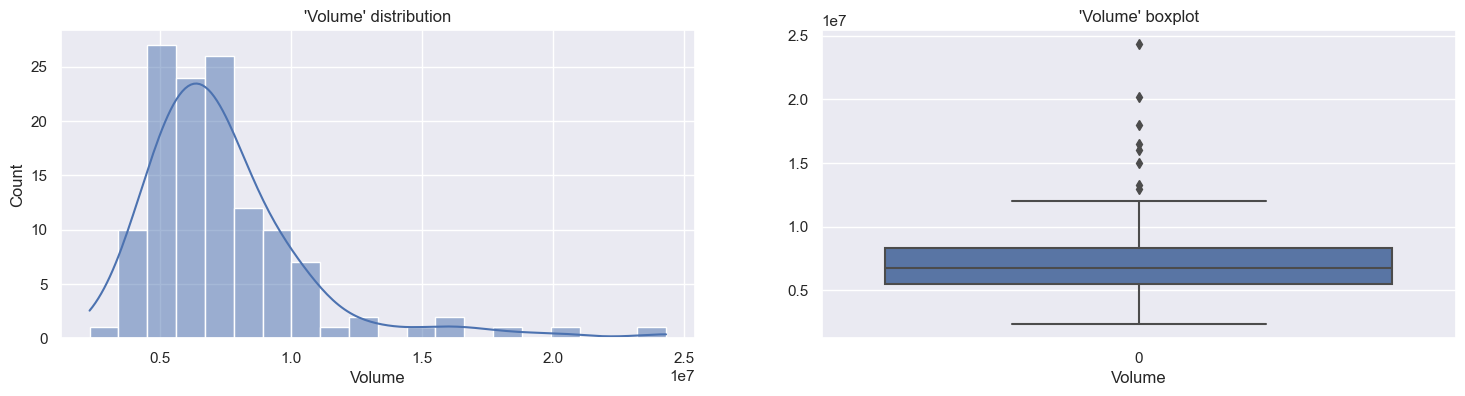

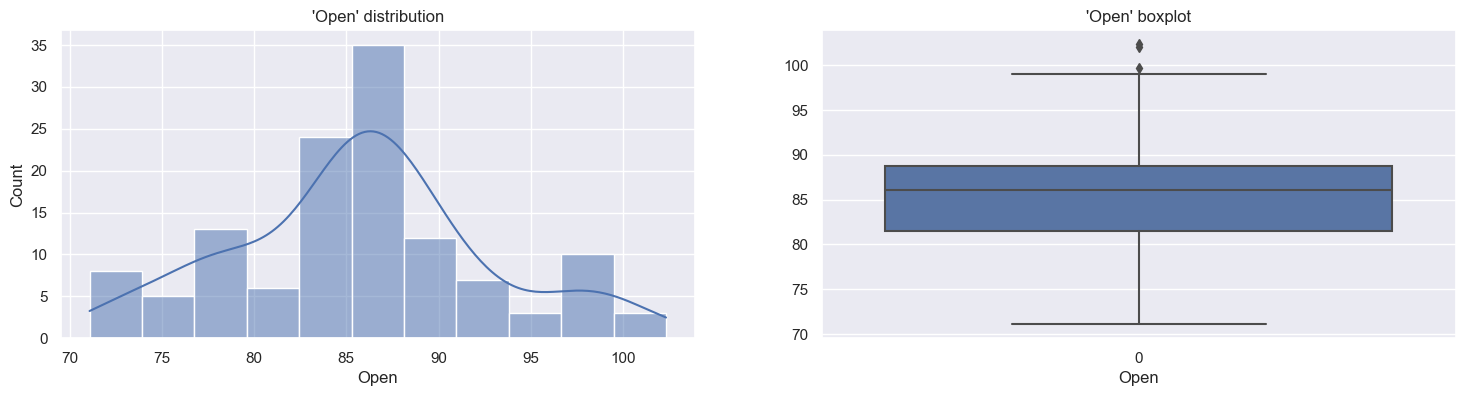

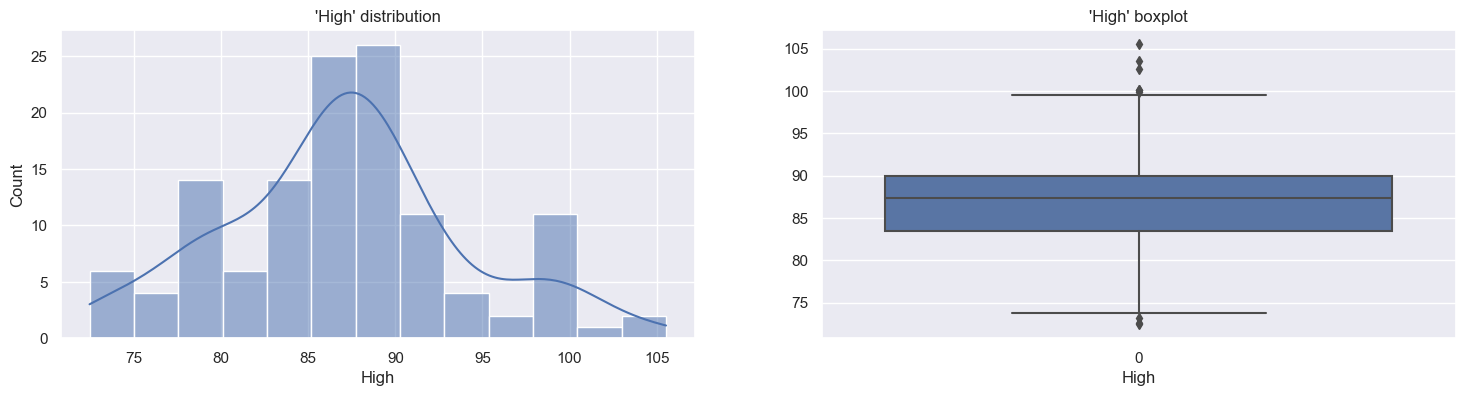

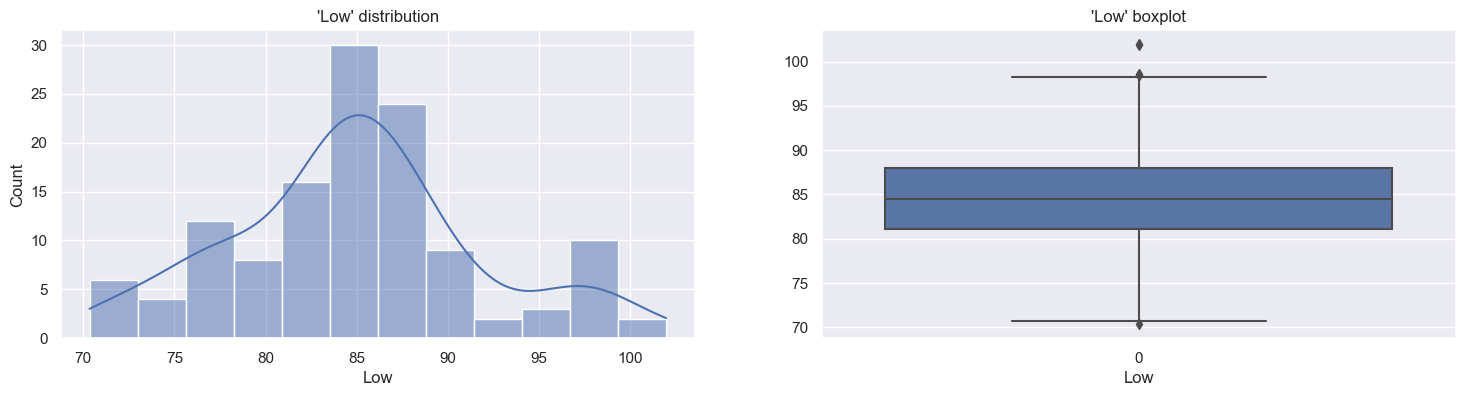

In [73]:
columns = [
    {"name": "Volume", "title": "Volume"},
    {"name": "Open", "title": "Open"},
    {"name": "High", "title": "High"},
    {"name": "Low", "title": "Low"}
]

for column in columns:
    get_distribution_plots(data[column["name"]], column["title"])


Columns _Close/Last_, _Open_, _High_ and _Low_ present a distribution close to a normal distribution, and their range of values could be extended in the future. z-score normalization will be used for these columns.

_Volume_ present a positive skewed distribution, and its observations show a magnitude of millions. log normalization will be used for this column.


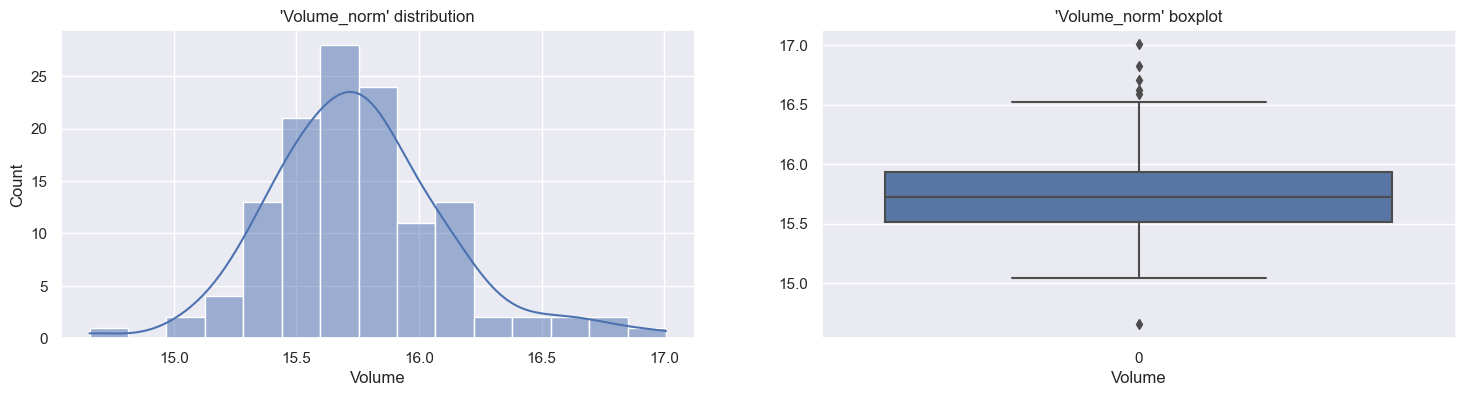

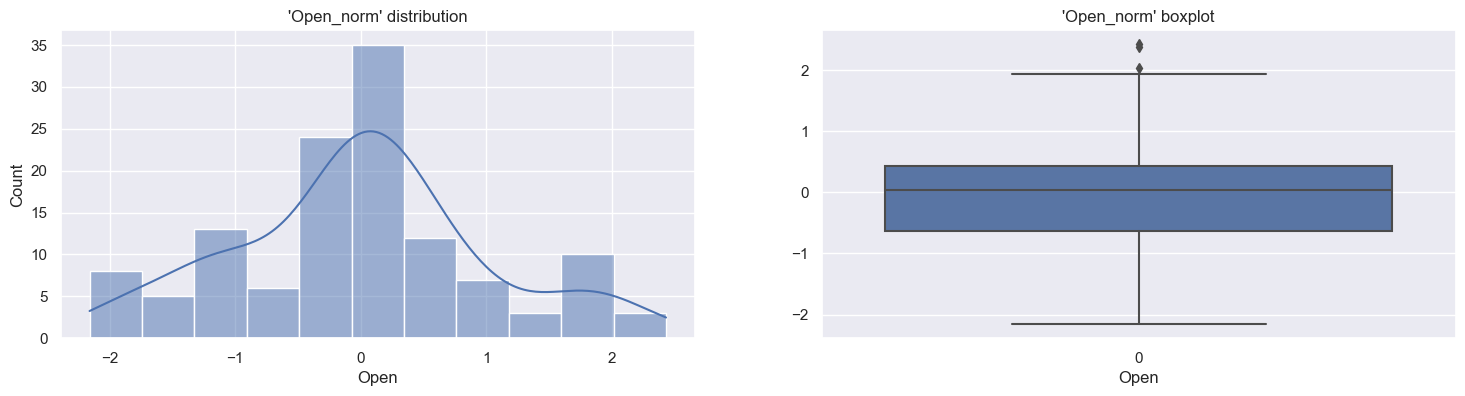

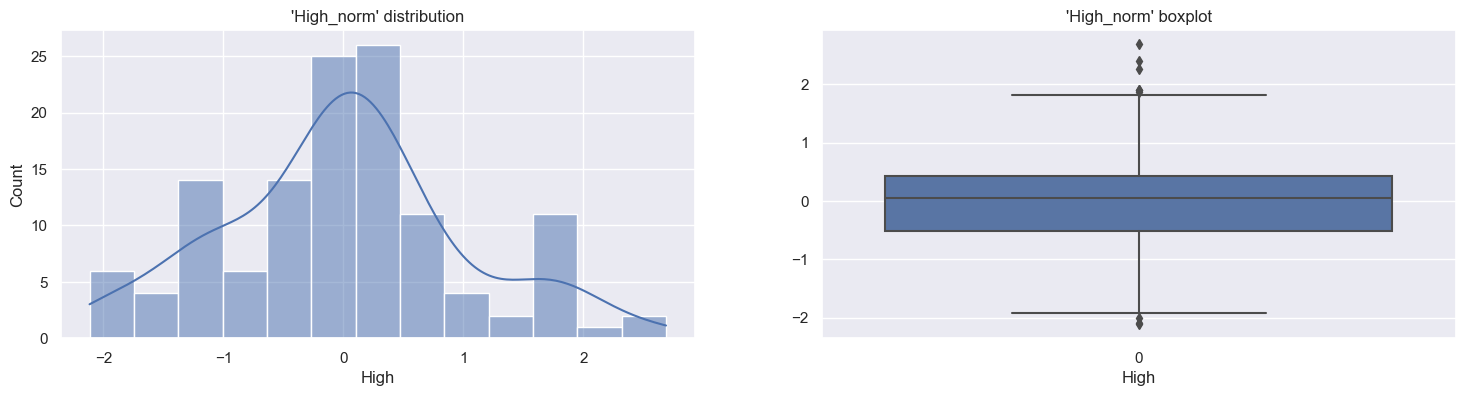

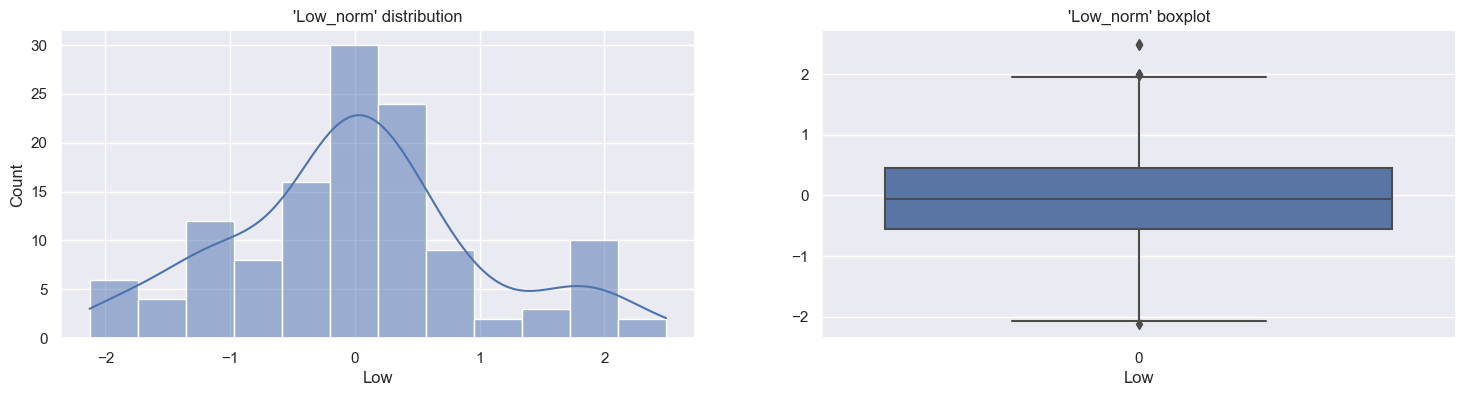

In [74]:
data_norm = data.copy()

scaler = StandardScaler()
data_norm["Close/Last"] = data_norm["Close/Last"]
data_norm["Open"] = scaler.fit_transform(data_norm[["Open"]])
data_norm["High"] = scaler.fit_transform(data_norm[["High"]])
data_norm["Low"] = scaler.fit_transform(data_norm[["Low"]])
data_norm["Volume"] = np.log(data_norm["Volume"])

columns = [
    {"name": "Volume", "title": "Volume_norm"},
    {"name": "Open", "title": "Open_norm"},
    {"name": "High", "title": "High_norm"},
    {"name": "Low", "title": "Low_norm"}
]

for column in columns:
    get_distribution_plots(data_norm[column["name"]], column["title"])



Additionally, We want to use month and day as attributes

In [75]:
data_norm["Day"] = data_norm["Date"].apply(lambda x: x.day)
data_norm["Month"] = data_norm["Date"].apply(lambda x: x.month)

data_norm.head()
 

,Date,Close/Last,Volume,Open,High,Low,Day,Month
0,2022-06-06,78.98,15.795053,-0.893910,-0.829038,-0.929916,6,6
1,2022-06-07,79.47,15.523363,-1.059841,-1.054012,-0.969384,7,6
2,2022-06-08,78.47,15.459978,-1.011383,-1.051138,-0.969384,8,6
3,2022-06-09,78.91,16.399365,-1.147946,-0.978532,-1.046859,9,6
4,2022-06-10,75.67,15.978313,-1.287446,-1.338514,-1.349450,10,6


In [76]:
data_norm.describe().T


,count,mean,std,min,25%,50%,75%,max
Close/Last,126.0,8.599611e+01,6.990851,70.950000,82.647500,85.810000,89.042500,105.050000
Volume,126.0,1.575470e+01,0.363572,14.657086,15.518909,15.725690,15.930805,17.006834
Open,126.0,1.268826e-15,1.003992,-2.159687,-0.623353,0.041474,0.430605,2.429123
High,126.0,-8.881784e-16,1.003992,-2.115088,-0.521151,0.057868,0.428737,2.689512
Low,126.0,-2.375525e-15,1.003992,-2.125662,-0.560586,-0.056494,0.450382,2.493603
Day,126.0,1.596032e+01,8.811266,1.000000,8.250000,16.000000,23.000000,31.000000
Month,126.0,8.619048e+00,1.719801,6.000000,7.000000,9.000000,10.000000,12.000000


### Feature selecction

We want to predict _Close/Last_ using regression, which attributes will be most useful to us?

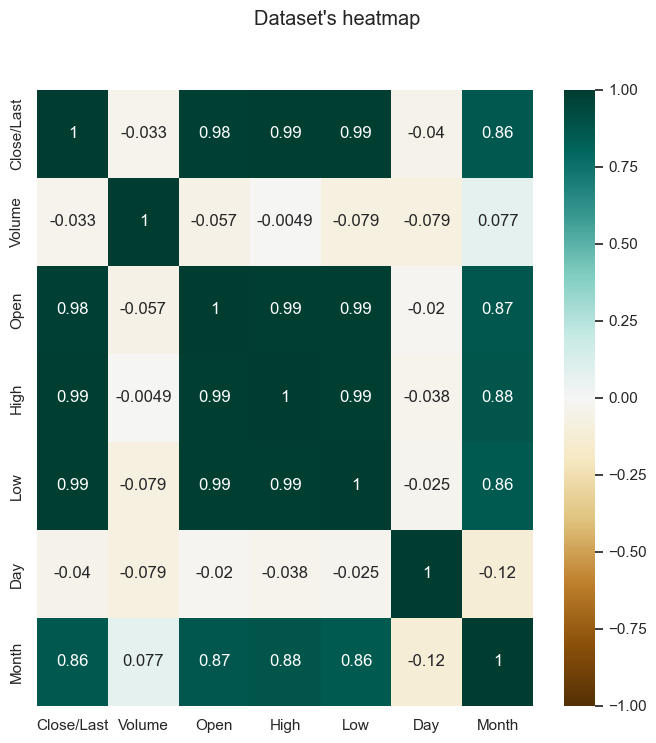

In [77]:
get_heatmap(data_norm.drop(columns=["Date"]))


We will use _Open_, _High_, _Low_ and _Month_ as predictors of _Close/Last_

In [78]:
date = data_norm[["Date"]].to_numpy()
Y = data_norm[["Close/Last"]].to_numpy()
X = data_norm[["Open", "High", "Low", "Month"]].to_numpy()


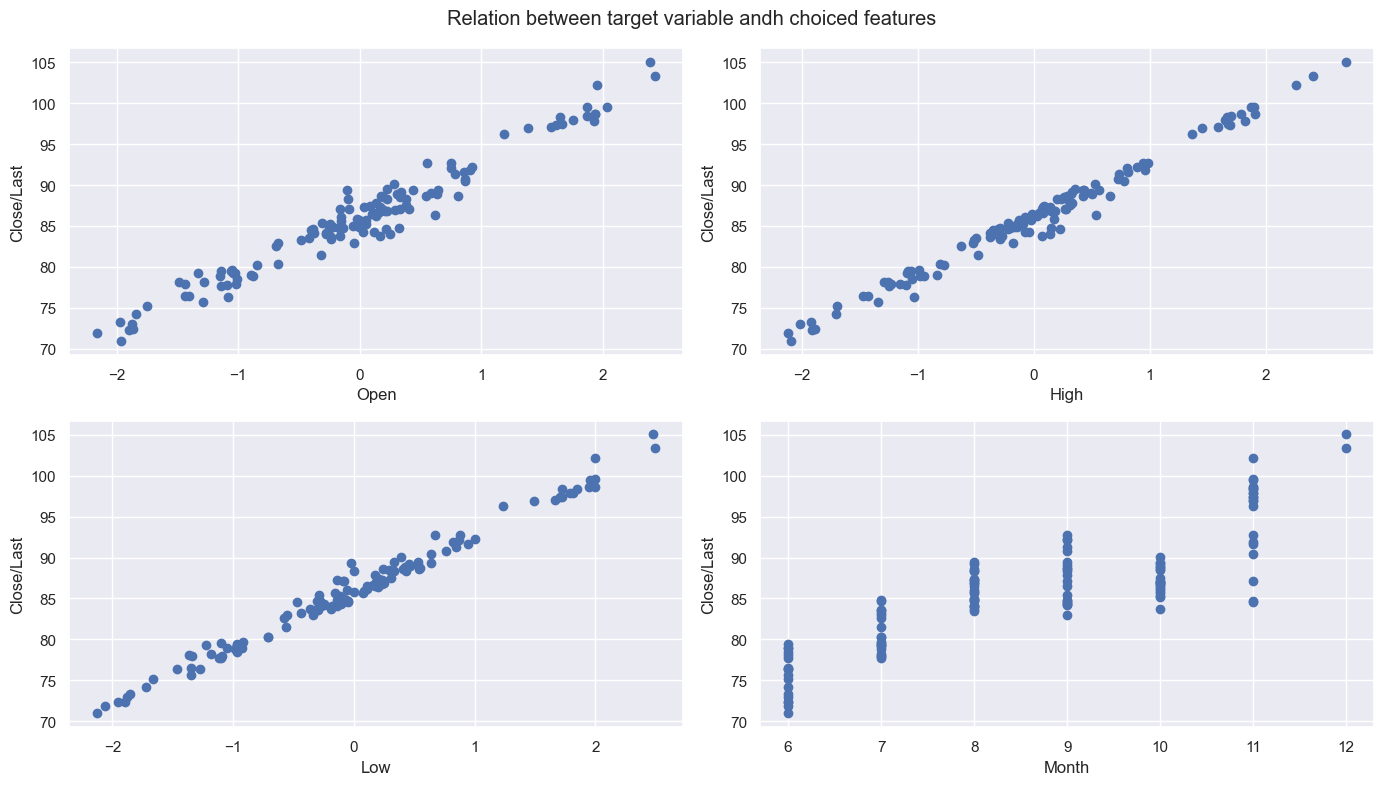

In [79]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 8)
fig.suptitle("Relation between target variable andh choiced features")

axes[0, 0].scatter(X[:, 0], Y)
axes[0, 0].set_ylabel("Close/Last")
axes[0, 0].set_xlabel("Open")

axes[0, 1].scatter(X[:, 1], Y)
axes[0, 1].set_ylabel("Close/Last")
axes[0, 1].set_xlabel("High")

axes[1, 0].scatter(X[:, 2], Y)
axes[1, 0].set_ylabel("Close/Last")
axes[1, 0].set_xlabel("Low")

axes[1, 1].scatter(X[:, 3], Y)
axes[1, 1].set_ylabel("Close/Last")
axes[1, 1].set_xlabel("Month")

plt.tight_layout()
plt.savefig(f"./figures/correlations.png", bbox_inches="tight")
plt.show()


Create train and test set

In [80]:
split_idx = int(np.floor(len(X) * 0.80))
date_train, date_test = date[:split_idx], date[split_idx:]
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

print(f"Total data: {len(Y)}")
print(f"Train data: {len(Y_train)}")
print(f"Test data: {len(Y_test)}")


Total data: 126
Train data: 100
Test data: 26


Let's see the evolution of _Close/Last_ over time

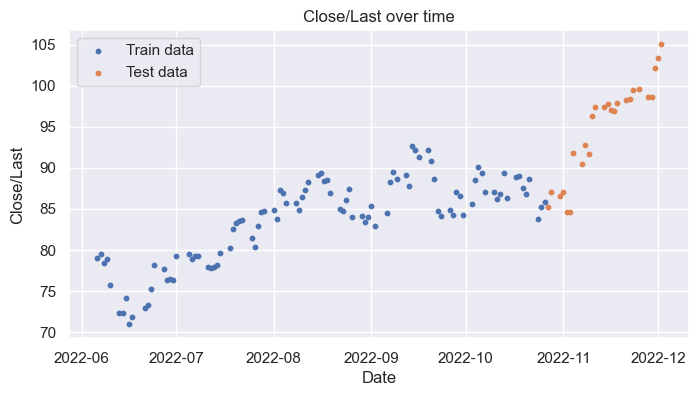

In [81]:
plt.figure(figsize=(8, 4))
plt.scatter(date_train, Y_train, s=10, label="Train data")
plt.scatter(date_test, Y_test, s=10, label="Test data")
plt.title("Close/Last over time")
plt.xlabel("Date")
plt.ylabel("Close/Last")
plt.legend()
plt.savefig(f"./figures/closelast_time.png", bbox_inches="tight")
plt.show()


## Simple linear regression

In [82]:
choiced_feature = 0

slr = LinearRegression()
slr.fit(X_train[:, choiced_feature].reshape(-1, 1), Y_train)
slr_train = slr.predict(X_train[:, choiced_feature].reshape(-1, 1))
slr_test = slr.predict(X_test[:, choiced_feature].reshape(-1, 1))


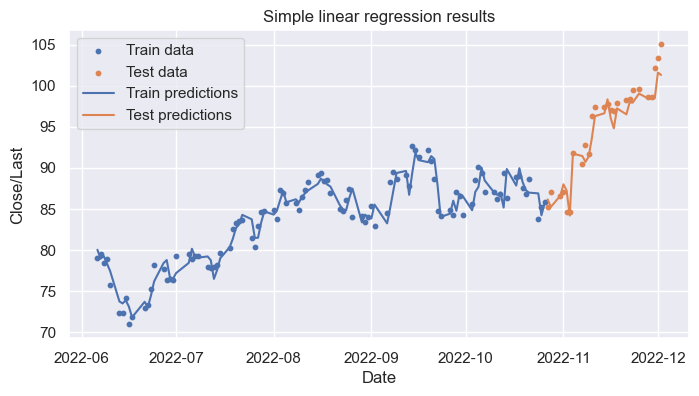

In [83]:
plot_predictions((date_train, Y_train), (date_test, Y_test), slr_train, slr_test, "Simple linear regression")


In [84]:
print("===== Simple Linear Regression Evaluation =====")
evaluate_regression(Y_test, slr_test)


===== Simple Linear Regression Evaluation =====
Mean Square Error: 2.71
Root Mean Square Error: 1.65
Mean Absolute Error: 1.28
Relative Square Error: 0.08
Pearson Correlation Coeficient: 0.98
R-squared: 0.92


## Polynomial regression

In [85]:
choiced_feature = 0
degree = 2

pr_feature = PolynomialFeatures(degree=degree, include_bias=False)
pr_feature = pr_feature.fit_transform(X_train[:, choiced_feature].reshape(-1, 1))

pr_feature_test = PolynomialFeatures(degree=degree, include_bias=False)
pr_feature_test = pr_feature_test.fit_transform(X_test[:, choiced_feature].reshape(-1, 1))

pr = LinearRegression()
pr.fit(pr_feature, Y_train)
pr_train = pr.predict(pr_feature)
pr_test = pr.predict(pr_feature_test)


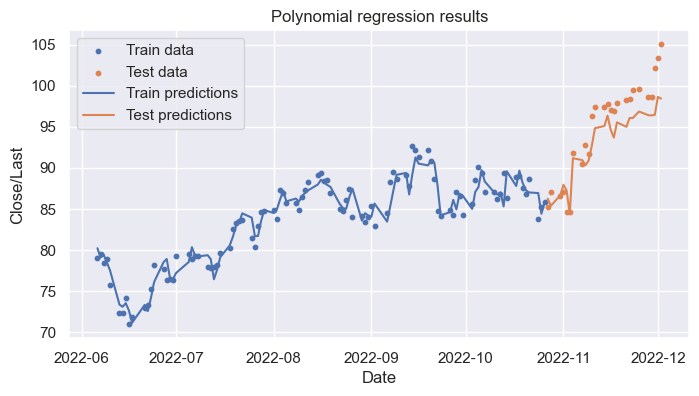

In [86]:
plot_predictions((date_train, Y_train), (date_test, Y_test), pr_train, pr_test, "Polynomial regression")


In [87]:
print("===== Polynomial Regression Evaluation =====")
evaluate_regression(Y_test, pr_test)


===== Polynomial Regression Evaluation =====
Mean Square Error: 8.22
Root Mean Square Error: 2.87
Mean Absolute Error: 2.4
Relative Square Error: 0.24
Pearson Correlation Coeficient: 0.97
R-squared: 0.76


## Multiple linear regression

In [88]:
mlr = LinearRegression()
mlr.fit(X_train, Y_train)
mlr_train = mlr.predict(X_train)
mlr_test = mlr.predict(X_test)


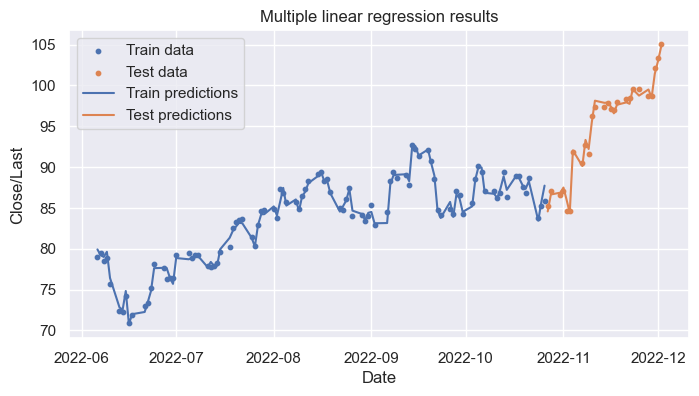

In [89]:
plot_predictions((date_train, Y_train), (date_test, Y_test), mlr_train, mlr_test, "Multiple linear regression")


In [90]:
print("===== Multiple Linear Regression Evaluation =====")
evaluate_regression(Y_test, mlr_test)


===== Multiple Linear Regression Evaluation =====
Mean Square Error: 0.33
Root Mean Square Error: 0.57
Mean Absolute Error: 0.49
Relative Square Error: 0.01
Pearson Correlation Coeficient: 1.0
R-squared: 0.99


## Ridge regression


In [91]:
rdr = Ridge(alpha=1.0)
rdr.fit(X_train, Y_train)
rdr_train = rdr.predict(X_train)
rdr_test = rdr.predict(X_test)


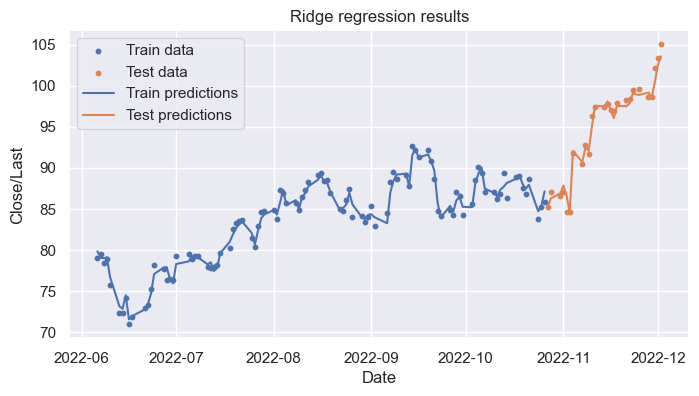

In [92]:
plot_predictions((date_train, Y_train), (date_test, Y_test), rdr_train, rdr_test, "Ridge regression")


In [93]:
print("===== Multiple Linear Regression Evaluation =====")
evaluate_regression(Y_test, rdr_test)


===== Multiple Linear Regression Evaluation =====
Mean Square Error: 0.64
Root Mean Square Error: 0.8
Mean Absolute Error: 0.6
Relative Square Error: 0.02
Pearson Correlation Coeficient: 0.99
R-squared: 0.98
